In [3]:
import numpy as np
import random as r
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib
r.seed(0)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, ShuffleSplit
import pandas as pd
import seaborn as sns

In [4]:
boston_data = load_boston()
print(boston_data.keys())
print(boston_data['DESCR'])

dict_keys(['DESCR', 'data', 'feature_names', 'target'])
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,0

# 1. Load the data into pandas DataFrame

In [5]:
data_with_target = np.hstack((boston_data['data'], boston_data['target'].reshape(-1, 1)))
feature_names_with_target = np.append(boston_data['feature_names'], 'MEDV')
df_with_target = pd.DataFrame(data_with_target, columns=feature_names_with_target)
df = df_with_target.drop('MEDV', axis=1)

In [6]:
df_descr = df.describe()
print(df_descr)

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.593761   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.596783   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.647423   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

# 2, 3. Dataset has 13 features, 506 examples

# 4. Plot each feature against ‘Median Value’ (housing price)

<IPython.core.display.Javascript object>


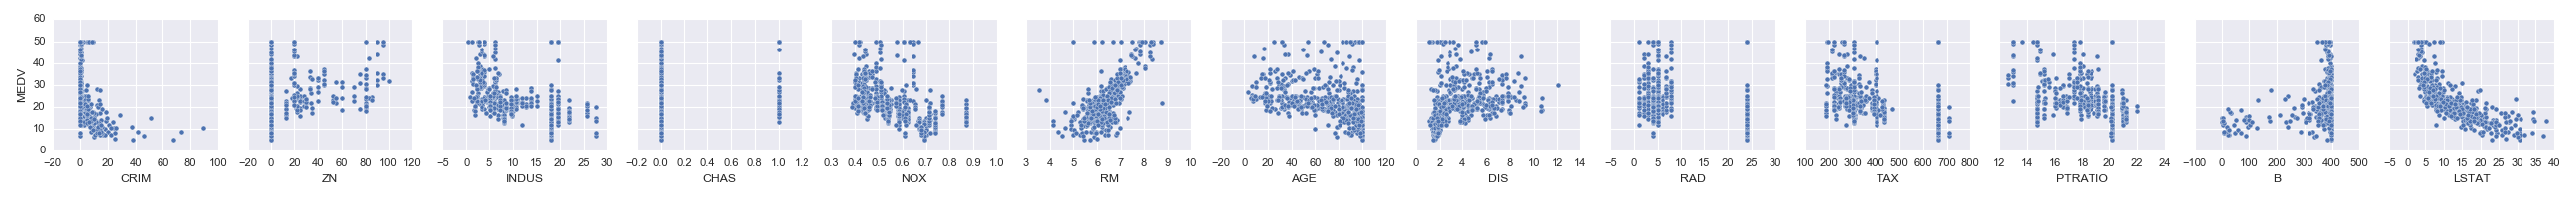

In [7]:
sns.pairplot(data=df_with_target, x_vars=df.columns, y_vars=['MEDV'])

I will choose 'RM', 'AGE' and 'LSTAT' attributes, because their values look spread out across 'x' axis and they seem to be easily described with a linear model. Also, it is a common sense that number of rooms and age are  relevant to housing price.

In [8]:
df_chosen = df[['RM', 'AGE', 'LSTAT']]

# 5. What are the statistics for the chosen variables

In [9]:
df_chosen.describe()

,RM,AGE,LSTAT
count,506.000000,506.000000,506.000000
mean,6.284634,68.574901,12.653063
std,0.702617,28.148861,7.141062
min,3.561000,2.900000,1.730000
25%,5.885500,45.025000,6.950000
50%,6.208500,77.500000,11.360000
75%,6.623500,94.075000,16.955000
max,8.780000,100.000000,37.970000


# 6. Split the data into the training and testing sets with train_test_split (testing set should contain 10% of all data)

In [10]:
ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, test_idx = next(ss.split(df))
print(len(train_idx), len(test_idx))

455 51


In [11]:
def get_linear_regression_quality_metrics(clf, data, target):
    return mean_squared_error(target, clf.predict(data)), clf.score(data, target)

In [12]:
def fit_linear_regression_and_report_quality_metrics(data, target, polynomial_features_degree=1, normalize=True):
    mses_train, mses_val, r2s_train, r2s_val = [], [], [], []
    # Prepare splits for cross-validation.
    ss = ShuffleSplit(n_splits=3, test_size=0.1, random_state=42)
    # Evaluate each train-val split.
    for train_idx, val_idx in ss.split(data):
        X_train, X_val, y_train, y_val = data[train_idx], data[val_idx], target[train_idx], target[val_idx]

        feat = PolynomialFeatures(degree=polynomial_features_degree)

        X_train = feat.fit_transform(X_train)
        X_val = feat.fit_transform(X_val)

        if normalize:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        clf = LinearRegression()
        clf.fit(X_train, y_train)
        
        mse_train_, r2_train_ = get_linear_regression_quality_metrics(clf, X_train, y_train)
        mse_val_, r2_val_ = get_linear_regression_quality_metrics(clf, X_val, y_val)
        
        mses_train.append(mse_train_)
        mses_val.append(mse_val_)
        r2s_train.append(r2_train_)
        r2s_val.append(r2_val_)
    
    print('MSE train: {:.2f} (+/- {:.2f})'.format(np.mean(mses_train), np.std(mses_train) * 2))
    print('MSE val: {:.2f} (+/- {:.2f})'.format(np.mean(mses_val), np.std(mses_val) * 2))
    print('R^2 train: {:.2f} (+/- {:.2f})'.format(np.mean(r2s_train), np.std(r2s_train) * 2))
    print('R^2 val: {:.2f} (+/- {:.2f})'.format(np.mean(r2s_val), np.std(r2s_val) * 2))
    
    # Fit classifier on all training data.
    feat = PolynomialFeatures(degree=polynomial_features_degree)
    X = feat.fit_transform(data)
    
    scaler = None
    if normalize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    clf = LinearRegression()
    clf.fit(X, target)
    
    return clf, scaler, feat

# 8. Fit the linear regression model on the training set. Report mean squared error and coefficient of determination R^2 on the training and testing sets

In [13]:
# Split dataframe and target to train-test using idx.
def train_test_split_df_and_target(df, target, train_idx, test_idx):
    return df.ix[train_idx], df.ix[test_idx], target[train_idx], target[test_idx]

In [14]:
def evaluate_df_features(df, train_idx, test_idx, polynomial_features_degree=1, normalize=True):
    print('features:', list(df.columns))
    df_train, df_test, target_train, target_test = \
      train_test_split_df_and_target(df, boston_data['target'], train_idx, test_idx)

    clf, scaler, feat = fit_linear_regression_and_report_quality_metrics(df_train.values, target_train, polynomial_features_degree, normalize)
    
    df_test = feat.fit_transform(df_test)
    print('Num input features:', df_test.shape[1])
    
    if normalize:
        df_test = scaler.transform(df_test)
    mse, r2 = get_linear_regression_quality_metrics(clf, df_test, target_test)
    print('MSE test: {:.2f}, R^2 test: {:.2f}'.format(mse, r2)) 

In [15]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 32.57 (+/- 0.47)
MSE val: 23.04 (+/- 4.20)
R^2 train: 0.63 (+/- 0.01)
R^2 val: 0.68 (+/- 0.14)
Num input features: 4
MSE test: 20.88, R^2 test: 0.67


# 9. Try to add more features, report which features you added and what influence it had on the model performance.


In [16]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'PTRATIO']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'PTRATIO']
MSE train: 28.79 (+/- 0.86)
MSE val: 22.93 (+/- 8.52)
R^2 train: 0.67 (+/- 0.01)
R^2 val: 0.69 (+/- 0.14)
Num input features: 5
MSE test: 17.12, R^2 test: 0.73


Adding PTRATIO increases model performance.

In [17]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'PTRATIO', 'NOX']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'PTRATIO', 'NOX']
MSE train: 28.53 (+/- 0.87)
MSE val: 22.48 (+/- 8.51)
R^2 train: 0.68 (+/- 0.01)
R^2 val: 0.69 (+/- 0.14)
Num input features: 6
MSE test: 16.79, R^2 test: 0.73


Adding NOX doesn't affect performance.

# 10. Polynomial features with normalization.

In [18]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=2)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 19.16 (+/- 0.16)
MSE val: 13.75 (+/- 1.35)
R^2 train: 0.78 (+/- 0.00)
R^2 val: 0.81 (+/- 0.03)
Num input features: 10
MSE test: 10.88, R^2 test: 0.83


In [19]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=3)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 17.22 (+/- 0.32)
MSE val: 12.63 (+/- 2.94)
R^2 train: 0.80 (+/- 0.00)
R^2 val: 0.83 (+/- 0.03)
Num input features: 20
MSE test: 8.87, R^2 test: 0.86


In [20]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=5)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 16.85 (+/- 8.01)
MSE val: 25.92 (+/- 31.48)
R^2 train: 0.81 (+/- 0.09)
R^2 val: 0.62 (+/- 0.57)
Num input features: 56
MSE test: 10.97, R^2 test: 0.82


In [21]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=7)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 15.33 (+/- 9.85)
MSE val: 219.26 (+/- 485.68)
R^2 train: 0.83 (+/- 0.11)
R^2 val: -2.43 (+/- 8.07)
Num input features: 120
MSE test: 82.35, R^2 test: -0.32


Increasing polynomial features degree impoves model perfomance on the training set. For degree=3 performance on the validation set is the best.

# 11. Polynomial features without normalization.

In [22]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=2, normalize=False)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 19.16 (+/- 0.16)
MSE val: 13.75 (+/- 1.35)
R^2 train: 0.78 (+/- 0.00)
R^2 val: 0.81 (+/- 0.03)
Num input features: 10
MSE test: 10.88, R^2 test: 0.83


In [23]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=5, normalize=False)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 14.15 (+/- 0.53)
MSE val: 18.96 (+/- 11.77)
R^2 train: 0.84 (+/- 0.00)
R^2 val: 0.73 (+/- 0.24)
Num input features: 56
MSE test: 10.95, R^2 test: 0.82


In [24]:
evaluate_df_features(df_chosen, train_idx, test_idx, polynomial_features_degree=7, normalize=False)

features: ['RM', 'AGE', 'LSTAT']
MSE train: 12.84 (+/- 1.75)
MSE val: 122.46 (+/- 271.41)
R^2 train: 0.85 (+/- 0.02)
R^2 val: -0.92 (+/- 4.51)
Num input features: 120
MSE test: 11.14, R^2 test: 0.82


# 12. Make some more features from existing features

In [25]:
df['LSTAT_SQ'] = df['LSTAT'] * df['LSTAT']
df['DIS_LOG'] = np.log(df['DIS'])
df['CRIM_LOG'] = np.log(df['CRIM'])

In [26]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'LSTAT_SQ']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'LSTAT_SQ']
MSE train: 25.94 (+/- 0.39)
MSE val: 16.29 (+/- 3.44)
R^2 train: 0.70 (+/- 0.00)
R^2 val: 0.78 (+/- 0.02)
Num input features: 5
MSE test: 17.51, R^2 test: 0.72


In [27]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS']
MSE train: 25.09 (+/- 0.27)
MSE val: 15.74 (+/- 2.28)
R^2 train: 0.71 (+/- 0.00)
R^2 val: 0.79 (+/- 0.03)
Num input features: 6
MSE test: 18.74, R^2 test: 0.70


In [28]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG']
MSE train: 25.03 (+/- 0.23)
MSE val: 15.92 (+/- 1.83)
R^2 train: 0.71 (+/- 0.01)
R^2 val: 0.79 (+/- 0.04)
Num input features: 7
MSE test: 19.19, R^2 test: 0.69


In [29]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG', 'CRIM']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG', 'CRIM']
MSE train: 23.19 (+/- 0.14)
MSE val: 14.94 (+/- 1.07)
R^2 train: 0.74 (+/- 0.01)
R^2 val: 0.80 (+/- 0.06)
Num input features: 8
MSE test: 17.59, R^2 test: 0.72


In [30]:
evaluate_df_features(df[['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG', 'CRIM_LOG']], train_idx, test_idx)

features: ['RM', 'AGE', 'LSTAT', 'LSTAT_SQ', 'DIS', 'DIS_LOG', 'CRIM_LOG']
MSE train: 24.26 (+/- 0.32)
MSE val: 16.07 (+/- 2.89)
R^2 train: 0.72 (+/- 0.01)
R^2 val: 0.78 (+/- 0.08)
Num input features: 8
MSE test: 18.79, R^2 test: 0.70


In [76]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

df_train, df_test, target_train, target_test = \
      train_test_split_df_and_target(df, boston_data['target'], train_idx, test_idx)

X_train = df_train.values
X_test = df_test.values

feat = PolynomialFeatures(degree=5)
X_poly_train = feat.fit_transform(X_train)
X_poly_test = feat.fit_transform(X_test)

poly_feature_names = feat.get_feature_names(df.columns)

scaler = StandardScaler()
X_poly_train = scaler.fit_transform(X_poly_train)
X_poly_test = scaler.transform(X_poly_test)
        
lasso_reg = Lasso()
lasso_reg.fit(X_poly_train, target_train)
mse_train, r2_train = get_linear_regression_quality_metrics(lasso_reg, X_poly_train, target_train)
mse_test, r2_test = get_linear_regression_quality_metrics(lasso_reg, X_poly_test, target_test)
print('MSE train:', mse_train, 'MSE test:', mse_test)
print('R^2 train:', r2_train, 'R^2 test:', r2_test)

model = SelectFromModel(lasso_reg, prefit=True)
selected_features_indices = model.get_support(indices=True)
selected_features = [poly_feature_names[i] for i in selected_features_indices]
print(selected_features)

MSE train: 19.8371147973 MSE test: 11.3877087187
R^2 train: 0.770998614497 R^2 test: 0.817604686102
['RM^4', 'RM^2 PTRATIO LSTAT', 'INDUS AGE DIS_LOG CRIM_LOG^2', 'INDUS DIS LSTAT CRIM_LOG^2', 'CHAS TAX^2 CRIM_LOG^2', 'NOX^3 DIS PTRATIO', 'NOX^2 DIS PTRATIO LSTAT', 'NOX RM DIS TAX LSTAT', 'NOX B LSTAT CRIM_LOG^2', 'RM^5', 'RM^4 B', 'RM^2 TAX B LSTAT', 'RM^2 PTRATIO^2 LSTAT']


In [74]:
evaluate_df_features(df[['CHAS', 'RM', 'PTRATIO', 'B', 'LSTAT']], train_idx, test_idx)

features: ['CHAS', 'RM', 'PTRATIO', 'B', 'LSTAT']
MSE train: 27.45 (+/- 0.79)
MSE val: 21.47 (+/- 7.97)
R^2 train: 0.69 (+/- 0.01)
R^2 val: 0.71 (+/- 0.10)
Num input features: 6
MSE test: 15.80, R^2 test: 0.75
